## Data Integration & Aggregation

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window

In [2]:
spark = SparkSession.builder \
.appName("brazilian-ecommerce") \
.config("spark.executor.memory","2g") \
.config("spark.executor.cores", "2") \
.config("spark.executor.instances", "2") \
.config("spark.sql.autoBroadcastJoinThreshold",20*1024*1024) \
.getOrCreate()

25/06/14 05:34:03 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [ ]:
path_head = "gs://bucket-name/ecommerce_real/"

df_customers = spark.read.parquet(f"{path_head}cleaned/customers", header=True)
df_geolocation = spark.read.parquet(f"{path_head}cleaned/geolocation", header=True)
df_order_items = spark.read.parquet(f"{path_head}cleaned/order_items", header=True)
df_order_payments = spark.read.parquet(f"{path_head}cleaned/order_payments", header=True)
df_order_reviews = spark.read.parquet(f"{path_head}cleaned/order_reviews", header=True)
df_orders = spark.read.parquet(f"{path_head}cleaned/orders", header=True)
df_products = spark.read.parquet(f"{path_head}cleaned/products", header=True)
df_sellers = spark.read.parquet(f"{path_head}cleaned/sellers", header=True)

In [5]:
df_orders.cache()
df_customers.cache()
df_order_items.cache()

DataFrame[order_id: string, product_id: string, seller_id: string, shipping_limit_date: timestamp, total_price: double, total_freight: double, qty: bigint, total_order_value: double]

### Join Tables

In [6]:
# first, join Orders and order_items Tables, then product, customers, and sellers
# Inner join dipilih karena kita hanya ingin menampilkan order yang punya item di dalamnya. 
# Order tanpa item tidak relevan untuk dianalisis, jadi tidak perlu dimasukkan ke hasil.

df_order_details = df_orders.join(df_order_items, 'order_id', 'inner')
df_order_details.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: date (nullable = true)
 |-- delivery_time: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- total_price: double (nullable = true)
 |-- total_freight: double (nullable = true)
 |-- qty: long (nullable = true)
 |-- total_order_value: double (nullable = true)



In [12]:
df_order_details = df_order_details.withColumn('qty', col('qty').cast('integer'))

In [13]:
df_order_details_full = df_order_details.join(broadcast(df_customers), 'customer_id', 'inner')

In [14]:
df_order_details_full = df_order_details_full.join(broadcast(df_products), 'product_id', 'inner')

In [15]:
df_order_details_full = df_order_details_full.join(broadcast(df_sellers), 'seller_id', 'inner')

In [16]:
df_order_details_full.printSchema()

root
 |-- seller_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: date (nullable = true)
 |-- delivery_time: integer (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- total_price: double (nullable = true)
 |-- total_freight: double (nullable = true)
 |-- qty: integer (nullable = true)
 |-- total_order_value: double (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- product_categ

In [17]:
# second join df_order_details_full with geolocation customer
# Di sini kita menggunakan left join karena kita ingin mempertahankan semua data dari df_order_details_full, 
# meskipun beberapa data tidak memiliki informasi lokasi yang cocok di df_geolocation.

df_order_details_full = df_order_details_full.alias("x") \
.join(
    broadcast(df_geolocation.alias("y")),
    col("x.customer_zip_code_prefix") == col("y.geolocation_zip_code_prefix"),
    how="left"
)

In [18]:
df_order_details_full = df_order_details_full.join(df_order_reviews, 'order_id', how="left")

In [19]:
df_order_details_full = df_order_details_full.join(df_order_payments, 'order_id', how="left")

In [20]:
df_order_details_full.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: date (nullable = true)
 |-- delivery_time: integer (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- total_price: double (nullable = true)
 |-- total_freight: double (nullable = true)
 |-- qty: integer (nullable = true)
 |-- total_order_value: double (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- product_categ

In [21]:
df_order_details_full.cache()

25/06/14 05:37:56 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[order_id: string, seller_id: string, product_id: string, customer_id: string, order_status: string, order_purchase_timestamp: timestamp, order_approved_at: timestamp, order_delivered_carrier_date: timestamp, order_delivered_customer_date: timestamp, order_estimated_delivery_date: date, delivery_time: int, shipping_limit_date: timestamp, total_price: double, total_freight: double, qty: int, total_order_value: double, customer_unique_id: string, customer_zip_code_prefix: string, customer_city: string, customer_state: string, product_category_name: string, product_category_name_english: string, product_name_length: int, product_description_length: int, product_photos_qty: int, product_weight_g: int, product_weight_kg: double, product_length_cm: int, product_height_cm: int, product_width_cm: int, product_volume_cm3: int, product_size_category: string, seller_zip_code_prefix: string, seller_city: string, seller_state: string, geolocation_zip_code_prefix: int, geolocation_lat: doub

### Aggregation

Do aggregation based on ecommerce usecase

In [22]:
df_order_details_full.count()

97182

In [24]:
df_order_details_full.agg(countDistinct("order_id")).show()

+------------------------+
|count(DISTINCT order_id)|
+------------------------+
|                   93592|
+------------------------+



### # Total Revenues Per Seller

In [25]:
# Total Revenues Per Seller

df_seller_revenue = df_order_details_full \
.groupBy("seller_id") \
.agg(round(sum("total_price"), 2).alias('total_revenue')) \
.orderBy(desc("total_revenue"))

In [26]:
df_seller_revenue.show(10, truncate=False)

+--------------------------------+-------------+
|seller_id                       |total_revenue|
+--------------------------------+-------------+
|4869f7a5dfa277a7dca6462dcf3b52b2|224665.33    |
|53243585a1d6dc2643021fd1853d8905|215041.44    |
|4a3ca9315b744ce9f8e9374361493884|194960.37    |
|fa1c13f2614d7b5c4749cbc52fecda94|188123.74    |
|7c67e1448b00f6e969d365cea6b010ab|180104.43    |
|7e93a43ef30c4f03f38b393420bc753a|162276.24    |
|da8622b14eb17ae2831f4ac5b9dab84a|157319.67    |
|7a67c85e85bb2ce8582c35f2203ad736|137803.81    |
|1025f0e2d44d7041d6cf58b6550e0bfa|137586.76    |
|955fee9216a65b617aa5c0531780ce60|130391.03    |
+--------------------------------+-------------+
only showing top 10 rows



### # Total Orders Per Customer

In [33]:
# Total Orders Per Customer
customer_total_orders = df_order_details_full.groupBy("customer_id") \
                                             .agg(count("order_id").alias("total_orders_per_customer")) \
                                             .orderBy(desc("total_orders_per_customer"))

In [34]:
customer_total_orders.show(10, truncate=False)

+--------------------------------+-------------------------+
|customer_id                     |total_orders_per_customer|
+--------------------------------+-------------------------+
|0d861a5e4dd6a9079d89e1330848f0ab|8                        |
|a67a246af6ba598a14cc86df3c0354ee|7                        |
|30bb84b541c96af98ba7d90b9ebf35d0|7                        |
|50920f8cd0681fd86ebe93670c8fe52e|6                        |
|c9dc6fff8500f3735822d5356bcb0e1b|6                        |
|223f5e3208f2fa202a8ff706a4d9b206|6                        |
|7171389ea6661b64e8c33ee5ad962922|6                        |
|5e312b0d9bf5c91599eb42120e633b19|6                        |
|6c44a903274653cddb1df3bcb05ac71f|6                        |
|e898b5ef24833b9cb9e2d4f00b937595|6                        |
+--------------------------------+-------------------------+
only showing top 10 rows



In [39]:
customer_total_orders.filter("customer_id = '0d861a5e4dd6a9079d89e1330848f0ab'").select("customer_id", "total_orders_per_customer").show()

+--------------------+-------------------------+
|         customer_id|total_orders_per_customer|
+--------------------+-------------------------+
|0d861a5e4dd6a9079...|                        8|
+--------------------+-------------------------+



In [36]:
df_order_details_full.filter("customer_id = '0d861a5e4dd6a9079d89e1330848f0ab'").select("customer_id", "order_id", "product_id").show()

+--------------------+--------------------+--------------------+
|         customer_id|            order_id|          product_id|
+--------------------+--------------------+--------------------+
|0d861a5e4dd6a9079...|ca3625898fbd48669...|0cf2faf9749f53924...|
|0d861a5e4dd6a9079...|ca3625898fbd48669...|1065e0ebef073787a...|
|0d861a5e4dd6a9079...|ca3625898fbd48669...|309dd69eb83cea38c...|
|0d861a5e4dd6a9079...|ca3625898fbd48669...|4a5c3967bfd3629fe...|
|0d861a5e4dd6a9079...|ca3625898fbd48669...|5dae498eff2d80057...|
|0d861a5e4dd6a9079...|ca3625898fbd48669...|678c229b41c0e497d...|
|0d861a5e4dd6a9079...|ca3625898fbd48669...|0de59eddc63167215...|
|0d861a5e4dd6a9079...|ca3625898fbd48669...|21b524c4c060169fa...|
+--------------------+--------------------+--------------------+



The customer with customer_id = '0d861a5e4dd6a9079d89e1330848f0ab' shows 8 orders in customer_total_orders, but all rows share the same order_id. This likely results from multiple items in a single order, so the correct total should be 1.

In [40]:
# Total Orders Per Customer Revisi
customer_total_orders_rev = df_order_details_full.groupBy("customer_id") \
                                             .agg(countDistinct("order_id").alias("total_orders_per_customer")) \
                                             .orderBy(desc("total_orders_per_customer"))

In [41]:
customer_total_orders_rev.filter("customer_id = '0d861a5e4dd6a9079d89e1330848f0ab'").select("customer_id", "total_orders_per_customer").show()

+--------------------+-------------------------+
|         customer_id|total_orders_per_customer|
+--------------------+-------------------------+
|0d861a5e4dd6a9079...|                        1|
+--------------------+-------------------------+



### # Average Review Score Per Seller

In [44]:
# Average Review Score Per Seller
avg_score_sellers = df_order_details_full.groupBy("seller_id")\
                                         .agg(avg("review_score").alias("average_rating"))

In [45]:
avg_score_sellers.show(5, truncate=False)

+--------------------------------+-----------------+
|seller_id                       |average_rating   |
+--------------------------------+-----------------+
|8e6cc767478edae941d9bd9eb778d77a|4.071428571428571|
|4d600e08ecbe08258c79e536c5a42fee|4.428571428571429|
|cb5ff1b9715e99589f3e0c7a6afab9e3|4.0              |
|62de60d81c55c29d76a6bce418b31cef|4.0              |
|038b75b729c8a9a04b0d07cba7eabe86|3.5              |
+--------------------------------+-----------------+
only showing top 5 rows



### # Most Sold Products ( Top 10 )

In [46]:
# Most Sold Products ( Top 10 ) -> berapa total barang produk itu dipesan
# Num orders -> berapa kali produk itu muncul di orderan customers
# Total Quantity -> berapa total barang produk yang terjual
top10_product = df_order_details_full.groupBy("product_id")\
                                     .agg(
                                        count("order_id").alias("num_orders"),
                                        sum("qty").alias("total_quantity")
                                     )\
                                     .orderBy("total_quantity", ascending=False)\
                                     .limit(10)

In [47]:
top10_product.show()

+--------------------+----------+--------------+
|          product_id|num_orders|total_quantity|
+--------------------+----------+--------------+
|aca2eb7d00ea1a7b8...|       422|           517|
|422879e10f4668299...|       346|           478|
|99a4788cb24856965...|       453|           474|
|389d119b48cf3043d...|       306|           386|
|368c6c730842d7801...|       288|           383|
|53759a2ecddad2bb8...|       281|           367|
|d1c427060a0f73f6b...|       309|           327|
|53b36df67ebb7c415...|       302|           318|
|154e7e31ebfa09220...|       262|           274|
|3dd2a17168ec895c7...|       252|           271|
+--------------------+----------+--------------+



### # Top Customers By Spending

In [48]:
# Top Customers By Spending
top10_customers = df_order_details_full.groupBy("customer_id") \
                                       .agg(round(sum("total_payment"),2).alias("total_spending"))\
                                       .orderBy(desc("total_spending")) \
                                       .limit(10)

In [49]:
top10_customers.show()

+--------------------+--------------+
|         customer_id|total_spending|
+--------------------+--------------+
|71901689c5f3e5adc...|      15978.65|
|1617b1357756262bf...|      13664.08|
|0d861a5e4dd6a9079...|       9258.24|
|cc803a2c412833101...|        8891.0|
|30bb84b541c96af98...|       8697.99|
|5e312b0d9bf5c9159...|       8530.14|
|ec5b2ba62e5743423...|       7274.88|
|c6e2731c5b391845f...|       6929.31|
|f48d464a0baaea338...|       6922.21|
|3fd6777bbce08a352...|       6726.66|
+--------------------+--------------+



In [42]:
df_order_details_full.filter(col("customer_id").startswith("71901689c5f3e5adc")).select("order_id", "customer_id", "product_id", "total_payment").show()

+--------------------+--------------------+--------------------+-------------+
|            order_id|         customer_id|          product_id|total_payment|
+--------------------+--------------------+--------------------+-------------+
|4412d97cb2093633a...|71901689c5f3e5adc...|03d817e5e392e7867...|      3195.73|
|4412d97cb2093633a...|71901689c5f3e5adc...|1179867d805886591...|      3195.73|
|4412d97cb2093633a...|71901689c5f3e5adc...|33e503f68fb60fe16...|      3195.73|
|4412d97cb2093633a...|71901689c5f3e5adc...|993ac19aa97507577...|      3195.73|
|4412d97cb2093633a...|71901689c5f3e5adc...|da7813106f94601e6...|      3195.73|
+--------------------+--------------------+--------------------+-------------+



### # Rank Top Selling Products Per seller

In [51]:
# Intermediate : 
# Rank Top Selling Products Per seller
# Hitung total revenue per seller & product
df_product_revenue = df_order_details_full.groupBy("seller_id", "product_id") \
    .agg(round(sum("total_price"),2).alias("product_revenue"))

window_spec = Window.partitionBy("seller_id").orderBy(desc("product_revenue"))

top_selling_products_by_seller = df_product_revenue.withColumn("rank", rank().over(window_spec)) \
    .filter(col("rank") <= 5)

top_selling_products_by_seller.show(truncate=False)

+--------------------------------+--------------------------------+---------------+----+
|seller_id                       |product_id                      |product_revenue|rank|
+--------------------------------+--------------------------------+---------------+----+
|0015a82c2db000af6aaaf3ae2ecb0532|a2ff5a97bf95719e38ea2e3b4105bce8|2685.0         |1   |
|001cca7ae9ae17fb1caed9dfb1094831|08574b074924071f4e201e151b152b4e|10335.3        |1   |
|001cca7ae9ae17fb1caed9dfb1094831|e251ebd2858be1aa7d9b2087a6992580|5453.1         |2   |
|001cca7ae9ae17fb1caed9dfb1094831|98a8c2fa16d7239c606640f5555768e4|3027.9         |3   |
|001cca7ae9ae17fb1caed9dfb1094831|547b95702aec86f05ac37e61d164891c|2040.5         |4   |
|001cca7ae9ae17fb1caed9dfb1094831|0da9ffd92214425d880de3f94e74ce39|1819.93        |5   |
|002100f778ceb8431b7a1020ff7ab48f|158102fe543dbaeb84d87811bfe06d0d|286.4          |1   |
|002100f778ceb8431b7a1020ff7ab48f|414c53fa9c5cc4a0390682aeb2e25ec1|210.8          |2   |
|002100f778ceb8431b7a

### # Calculate AOV Average Order Value per customer (customer-level)


In [50]:
# Calculate AOV Average Order Value per customer (customer-level)
order_level_df = df_order_details_full.groupBy("customer_id", "order_id").agg(
    sum("total_payment").alias("order_total")
)

# Step 2: Hitung AOV per customer
customer_aov_df = order_level_df.groupBy("customer_id").agg(
    count("order_id").alias("total_orders"),
    sum("order_total").alias("total_spent"),
    round(avg("order_total"), 2).alias("AOV")
)

customer_aov_df.show()

+--------------------+------------+-----------+------+
|         customer_id|total_orders|total_spent|   AOV|
+--------------------+------------+-----------+------+
|d927892e658a6af91...|           1|      260.5| 260.5|
|8f4758b55faa41da5...|           1|      61.01| 61.01|
|ca85f1de72b224e6e...|           1|     206.09|206.09|
|136f8c475ac7abd11...|           1|     209.48|209.48|
|44e0884274cbedabc...|           1|     153.38|153.38|
|2daf50201a5e309f6...|           1|     175.16|175.16|
|82c91e8e62d9d79bf...|           1|     210.29|210.29|
|35c922a335b8a9141...|           1|      47.11| 47.11|
|90d7075599361b694...|           1|     168.56|168.56|
|d9f57c5a009cd22a4...|           1|      27.69| 27.69|
|9e805b75d4ed5080a...|           1|     225.84|225.84|
|62189b05812bf34dc...|           1|      106.0| 106.0|
|2aec499f94f5e8278...|           1|     215.83|215.83|
|f0f97266247be0432...|           1|       62.5|  62.5|
|0721e1c4b91bc6ded...|           1|     107.78|107.78|
|c79c8d356

In [159]:
# Buat sample data
data = [
    ("C1", "O1", "A", 2, 100),
    ("C1", "O1", "B", 1, 50),
    ("C1", "O2", "C", 3, 90),
    ("C2", "O3", "A", 1, 100),
    ("C2", "O4", "B", 2, 120),
    ("C2", "O4", "C", 1, 80),
]

columns = ["customer_id", "order_id", "product_id", "qty", "total_payment"]
df = spark.createDataFrame(data, columns)

# Step 1: Total belanja per order
order_level_df = df.groupBy("customer_id", "order_id").agg(
    sum("total_payment").alias("order_total")
)

# Step 2: Hitung AOV per customer
customer_aov_df = order_level_df.groupBy("customer_id").agg(
    count("order_id").alias("total_orders"),
    sum("order_total").alias("total_spent"),
    round(avg("order_total"), 2).alias("AOV")
)

customer_aov_df.show()

+-----------+------------+-----------+-----+
|customer_id|total_orders|total_spent|  AOV|
+-----------+------------+-----------+-----+
|         C2|           2|        300|150.0|
|         C1|           2|        240|120.0|
+-----------+------------+-----------+-----+



In [161]:
# Buat data dummy
data = [
    ('C1', 'O1', 'A', 50),
    ('C1', 'O1', 'A', 50),
    ('C1', 'O1', 'B', 50),
    ('C1', 'O2', 'C', 30),
    ('C1', 'O2', 'C', 30),
    ('C1', 'O2', 'C', 30),
    ('C2', 'O3', 'A', 100),
    ('C2', 'O4', 'B', 60),
    ('C2', 'O4', 'B', 60),
    ('C2', 'O4', 'C', 80)
]

columns = ["customer_id", "order_id", "product_id", "price"]
df = spark.createDataFrame(data, columns)

# Step 1: total pembayaran per order
order_level_df = df.groupBy("customer_id", "order_id").agg(
    sum("price").alias("order_total")
)

# Step 2: hitung AOV per customer
customer_aov_df = order_level_df.groupBy("customer_id").agg(
    count("order_id").alias("total_orders"),
    sum("order_total").alias("total_spent"),
    round(avg("order_total"), 2).alias("AOV")
)

customer_aov_df.show()

+-----------+------------+-----------+-----+
|customer_id|total_orders|total_spent|  AOV|
+-----------+------------+-----------+-----+
|         C2|           2|        300|150.0|
|         C1|           2|        240|120.0|
+-----------+------------+-----------+-----+



### # Seller Performance Metrics ( Revenue, Average Review, Order Count)

In [54]:
# Seller Performance Metrics ( Revenue, Average Review, Order Count)
df_seller_metrics = df_order_details_full \
.groupBy("seller_id") \
.agg(round(sum("total_price"), 2).alias('total_revenue'),
     round(avg("review_score"), 1).alias("average_rating"),
     countDistinct("order_id").alias("num_orders")) \
.orderBy(desc("total_revenue"))

In [55]:
df_seller_metrics.show()

+--------------------+-------------+--------------+----------+
|           seller_id|total_revenue|average_rating|num_orders|
+--------------------+-------------+--------------+----------+
|4869f7a5dfa277a7d...|    224665.33|           4.2|      1112|
|53243585a1d6dc264...|    215041.44|           4.2|       345|
|4a3ca9315b744ce9f...|    194960.37|           3.9|      1756|
|fa1c13f2614d7b5c4...|    188123.74|           4.4|       566|
|7c67e1448b00f6e96...|    180104.43|           3.5|       936|
|7e93a43ef30c4f03f...|    162276.24|           4.4|       314|
|da8622b14eb17ae28...|    157319.67|           4.1|      1285|
|7a67c85e85bb2ce85...|    137803.81|           4.3|      1133|
|1025f0e2d44d7041d...|    137586.76|           4.0|       905|
|955fee9216a65b617...|    130391.03|           4.2|      1242|
|6560211a19b47992c...|    117760.84|           4.0|      1775|
|5dceca129747e92ff...|    110876.74|           4.0|       321|
|46dc3b2cc0980fb8e...|    110242.89|           4.3|    

In [65]:
df_order_details_full.groupBy("seller_id", "order_id").count().filter("count > 1").show()

+--------------------+--------------------+-----+
|           seller_id|            order_id|count|
+--------------------+--------------------+-----+
|8a130737016f83813...|ac899f448f474ceb2...|    2|
|4992e76a42cb3aad7...|d65f26752fd6834bf...|    2|
|1f50f920176fa81da...|bbf6f71330cce4afd...|    2|
|30a2f535bb48308f9...|112b993827414a482...|    2|
|4a1f694197d05fe70...|3f13c6c8bb6e531e0...|    3|
|318f287a62ab7ac10...|a436479c10d07646d...|    2|
|1f50f920176fa81da...|117e77b39bc8cd4a2...|    2|
|272f092de69afedd4...|772b70d3a8f138f49...|    2|
|d20b021d3efdf267a...|b8c38cf37cd17fd64...|    3|
|cb3dd9ce66268c7a3...|bcb0343717a9e0265...|    2|
|ea8482cd71df3c196...|e2fcc0343a77288cc...|    2|
|d2374cbcbb3ca4ab1...|1c437b4d4326d36b7...|    2|
|cca3071e3e9bb7d12...|200f4d883fcc70135...|    6|
|897060da8b9a21f65...|09b584a0cd8717a01...|    2|
|8160255418d5aaa7d...|4845232ae57f7a442...|    3|
|b4f8921fcc4ff77b6...|764bcaebe1a019d6c...|    2|
|d2374cbcbb3ca4ab1...|2f7b0d36ffcaf0277...|    2|


Kalau ada hasilnya, berarti 1 seller muncul lebih dari sekali per order, yang artinya memang butuh countDistinct.

In [62]:
df_order_details_full.filter(col("seller_id").startswith("edb1ef5e36e0c8cd8")).select("seller_id", "product_id", "order_id").groupBy("order_id").count().filter("count > 1").show()

+--------------------+-----+
|            order_id|count|
+--------------------+-----+
|7d7688ff6a1534fab...|    2|
|f52a5a508f96400a0...|    2|
+--------------------+-----+



In [64]:
df_order_details_full.filter(col("seller_id").startswith("edb1ef5e36e0c8cd8")).select("seller_id", "product_id", "order_id", "customer_id").filter(col("order_id").startswith("7d7688ff6a1534fab")).show()

+--------------------+--------------------+--------------------+--------------------+
|           seller_id|          product_id|            order_id|         customer_id|
+--------------------+--------------------+--------------------+--------------------+
|edb1ef5e36e0c8cd8...|c43b672f48eaccbec...|7d7688ff6a1534fab...|2e94ea544f81f32c3...|
|edb1ef5e36e0c8cd8...|e4985e03cd939f1a9...|7d7688ff6a1534fab...|2e94ea544f81f32c3...|
+--------------------+--------------------+--------------------+--------------------+



### # Monthly Revenue and Order Count Trend

In [ ]:
# Monthly Revenue and Order Count Trend ----> HW

# order_purchase_timestamp ---> month

# total_orders 
# total_revenue
# avg_order_value
# min_order_value
# max_orderValues

In [68]:
df_order_details_full.select("order_purchase_timestamp").agg(max('order_purchase_timestamp'), min('order_purchase_timestamp')).show()

+-----------------------------+-----------------------------+
|max(order_purchase_timestamp)|min(order_purchase_timestamp)|
+-----------------------------+-----------------------------+
|          2018-08-28 22:51:54|          2016-10-03 09:44:50|
+-----------------------------+-----------------------------+



In [77]:
# Secara rata-rata, bulan apa yang paling tinggi revenue-nya?
df_order_details_full.withColumn("month", month("order_purchase_timestamp")) \
    .groupBy("month") \
    .agg(round(sum("total_price"),2).alias("monthly_revenue"),
         countDistinct("order_id").alias("total_orders")) \
    .withColumn("avg_order_value", col("monthly_revenue")/col("total_orders")) \
    .orderBy("month") \
    .show()

+-----+---------------+------------+------------------+
|month|monthly_revenue|total_orders|   avg_order_value|
+-----+---------------+------------+------------------+
|    1|      987156.31|        7505| 131.5331525649567|
|    2|     1009762.51|        7831|128.94426126931427|
|    3|     1257311.48|        9155| 137.3360436919716|
|    4|      1278545.6|        8848|144.50108499095842|
|    5|     1436025.14|       10066|142.66095171865686|
|    6|     1250004.47|        9023|138.53535077025379|
|    7|     1324836.23|        9829| 134.7885064604741|
|    8|     1371754.42|       10314|132.99926507659492|
|    9|      594869.21|        4042| 147.1719965363681|
|   10|      665953.41|        4638|143.58633247089264|
|   11|      951446.06|        7059|  134.784822212778|
|   12|      686403.66|        5282| 129.9514691404771|
+-----+---------------+------------+------------------+



In [96]:
# Monthly Revenue dari Oktober 2016 sampai Agustus 2018
df_order_details_full = df_order_details_full.withColumn("year_month", date_format("order_purchase_timestamp", "yyyy-MM"))

df_monthly_revenue_trend = df_order_details_full \
    .groupBy("year_month") \
    .agg(round(sum("total_price"),2).alias("monthly_revenue"),
         countDistinct("order_id").alias("total_orders")) \
    .withColumn("avg_order_value", round(col("monthly_revenue")/col("total_orders"),2)) \
    .orderBy("year_month")

In [97]:
df_monthly_revenue_trend.show(50)

+----------+---------------+------------+---------------+
|year_month|monthly_revenue|total_orders|avg_order_value|
+----------+---------------+------------+---------------+
|   2016-10|       39208.56|         255|         153.76|
|   2016-12|           10.9|           1|           10.9|
|   2017-01|      105436.45|         723|         145.83|
|   2017-02|      221159.07|        1577|         140.24|
|   2017-03|      347489.86|        2459|         141.31|
|   2017-04|      327243.22|        2222|         147.27|
|   2017-05|      474248.27|        3437|         137.98|
|   2017-06|      409923.48|        3053|         134.27|
|   2017-07|      472116.94|        3780|          124.9|
|   2017-08|      544668.25|        4088|         133.24|
|   2017-09|      594869.21|        4042|         147.17|
|   2017-10|      626744.85|        4383|         142.99|
|   2017-11|      951446.06|        7059|         134.78|
|   2017-12|      686392.76|        5281|         129.97|
|   2018-01|  

<Axes: xlabel='year_month'>

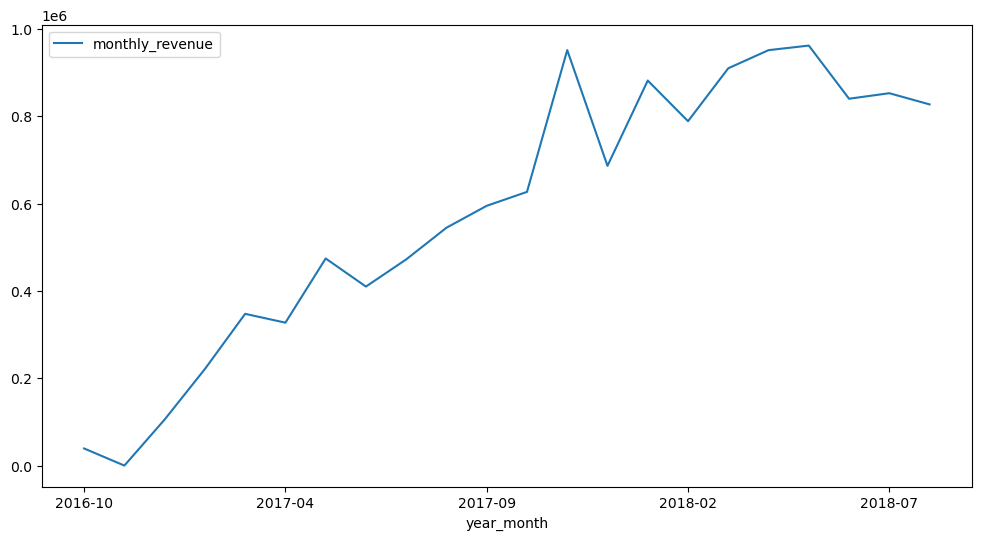

In [101]:
df_monthly_revenue_trend_pd = df_monthly_revenue_trend.toPandas()
df_monthly_revenue_trend_pd.plot(x="year_month", y=["monthly_revenue"], figsize=(12,6))

In [112]:
df_order_value = df_order_details_full.groupBy("order_id") \
    .agg(sum("total_price").alias("total_order_value"),
         date_format(first("order_purchase_timestamp"), "yyyy-MM").alias("year_month")) \
    .groupBy("year_month") \
    .agg(min("total_order_value"), max("total_order_value"))

In [113]:
df_monthly_revenue_trend_join = df_monthly_revenue_trend.join(df_order_value, 'year_month', 'inner').orderBy("year_month")
df_monthly_revenue_trend_join.show(50)

+----------+---------------+------------+---------------+----------------------+----------------------+
|year_month|monthly_revenue|total_orders|avg_order_value|min(total_order_value)|max(total_order_value)|
+----------+---------------+------------+---------------+----------------------+----------------------+
|   2016-10|       39208.56|         255|         153.76|                   6.0|                1399.0|
|   2016-12|           10.9|           1|           10.9|                  10.9|                  10.9|
|   2017-01|      105436.45|         723|         145.83|                   2.9|                2999.0|
|   2017-02|      221159.07|        1577|         140.24|                   5.9|                6735.0|
|   2017-03|      347489.86|        2459|         141.31|                   4.9|                3999.9|
|   2017-04|      327243.22|        2222|         147.27|                   4.9|                4799.0|
|   2017-05|      474248.27|        3437|         137.98|       

In [116]:
# Cara kedua lebih sederhana

df_order_value = df_order_details_full.groupBy("order_id") \
    .agg(sum("total_price").alias("order_value"),
         date_format(first("order_purchase_timestamp"), "yyyy-MM").alias("year_month"))

df_monthly_revenue_trend = df_order_value.groupBy("year_month") \
    .agg(
        round(sum("order_value"), 2).alias("monthly_revenue"),
        count("order_id").alias("total_orders"),
        round(min("order_value"), 2).alias("min_order_value"),
        round(max("order_value"), 2).alias("max_order_value"),
        round(avg("order_value"), 2).alias("avg_order_value")
    ).orderBy("year_month")

In [117]:
df_monthly_revenue_trend.show(50)

+----------+---------------+------------+---------------+---------------+---------------+
|year_month|monthly_revenue|total_orders|min_order_value|max_order_value|avg_order_value|
+----------+---------------+------------+---------------+---------------+---------------+
|   2016-10|       39208.56|         255|            6.0|         1399.0|         153.76|
|   2016-12|           10.9|           1|           10.9|           10.9|           10.9|
|   2017-01|      105436.45|         723|            2.9|         2999.0|         145.83|
|   2017-02|      221159.07|        1577|            5.9|         6735.0|         140.24|
|   2017-03|      347489.86|        2459|            4.9|         3999.9|         141.31|
|   2017-04|      327243.22|        2222|            4.9|         4799.0|         147.27|
|   2017-05|      474248.27|        3437|            4.5|         6499.0|         137.98|
|   2017-06|      409923.48|        3053|           3.49|        2999.89|         134.27|
|   2017-0

### # Customer Retention Analysis ( First & Last Order )


In [118]:
# Customer Retention Analysis ( First & Last Order )
df_customer_lifespan = df_orders.groupBy("customer_id") \
    .agg(
        min("order_purchase_timestamp").alias("first_order_date"),
        max("order_purchase_timestamp").alias("last_order_date")
    ) \
    .withColumn("days_between", datediff("last_order_date", "first_order_date")) \
    .orderBy(desc("days_between"))

In [119]:
df_customer_lifespan.show()

+--------------------+-------------------+-------------------+------------+
|         customer_id|   first_order_date|    last_order_date|days_between|
+--------------------+-------------------+-------------------+------------+
|2ef8398f62042a2b4...|2017-11-21 20:48:32|2017-11-21 20:48:32|           0|
|30af142d1d13f49ef...|2018-02-23 23:24:49|2018-02-23 23:24:49|           0|
|90d7075599361b694...|2017-07-28 17:03:33|2017-07-28 17:03:33|           0|
|3391c4bc11a817e79...|2018-03-26 17:12:18|2018-03-26 17:12:18|           0|
|57d74bba7d8b5157d...|2017-06-23 09:27:56|2017-06-23 09:27:56|           0|
|9687241c8ed401845...|2017-06-03 10:33:55|2017-06-03 10:33:55|           0|
|c61b59e94df1163ca...|2018-03-06 13:22:10|2018-03-06 13:22:10|           0|
|18dff7c2afb1ce5fb...|2017-11-24 12:59:43|2017-11-24 12:59:43|           0|
|9801ac60f0291d180...|2018-07-02 12:00:14|2018-07-02 12:00:14|           0|
|21d2c3ed27ae18bdb...|2018-04-23 13:49:33|2018-04-23 13:49:33|           0|
|ac9b518157b

In [121]:
df_customer_lifespan.groupBy("days_between").agg(count("*").alias("customer_count")).orderBy("days_between").show()

+------------+--------------+
|days_between|customer_count|
+------------+--------------+
|           0|         94912|
+------------+--------------+



Customer Retention Analysis (First & Last Order)

Analisis ini bertujuan untuk mengukur rentang waktu antara pembelian pertama dan terakhir 
yang dilakukan oleh setiap customer, sebagai dasar untuk melihat tingkat retensi pelanggan.
Namun, berdasarkan data yang tersedia, setiap customer hanya memiliki satu order (satu order_id).
Akibatnya, tanggal pembelian pertama dan terakhir selalu sama, sehingga nilai days_between = 0 untuk semua customer.
Dengan kondisi ini, analisis retensi tidak dapat dilakukan lebih lanjut karena tidak ada pembelian berulang.


### # Order Revenue Calcualtion

In [123]:
# Order Revenue Calcualtion
df_order_details_full.printSchema()
# total_order_value -> total_price + total_freight untuk 1 product_id yang berjumlah n qty

root
 |-- order_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: date (nullable = true)
 |-- delivery_time: integer (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- total_price: double (nullable = true)
 |-- total_freight: double (nullable = true)
 |-- qty: integer (nullable = true)
 |-- total_order_value: double (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- product_categ

In [128]:
df_order_details_full.groupBy("order_id").agg(round(sum("total_order_value"),2).alias("total_revenue(price&freight)")).show()

+--------------------+----------------------------+
|            order_id|total_revenue(price&freight)|
+--------------------+----------------------------+
|019886de8f385a39b...|                       188.4|
|05bef443b85068505...|                       79.52|
|077700dcf4e3bb412...|                      215.05|
|0e4672661531addf3...|                     1304.02|
|118045506e1c1dda0...|                       360.4|
|12404c66f4ea97b16...|                       62.44|
|14129c568e62c007a...|                      152.35|
|1826d2a2eb6ba6e3e...|                      232.83|
|1c4a92d82c1b0dec1...|                      249.05|
|236d48ee787db9dbd...|                        51.1|
|251f0a3981c4a8cb8...|                       93.15|
|3303092810c37e9ab...|                      559.26|
|39a2c5163845188e0...|                      176.78|
|3e5d60bbe5a6016db...|                       22.75|
|3e654c7f3c4a852f6...|                      136.93|
|414a0b1cbb58b3ae7...|                       78.96|
|43ed2e201f5

### # Customer Segmentation based on spending

In [136]:
# Customer Segmentation based on spending -> ambil dari customer_aov_df

customer_segmentation = customer_aov_df \
.withColumn("total_spent", round("total_spent",2)) \
.withColumn("segment", 
    when(col("total_spent") >= 8000, "Top Spender")
   .when(col("total_spent") >= 5000, "High Spender")
   .when(col("total_spent") >= 1000, "Mid Spender")
   .otherwise("Low Spender")
).orderBy(desc("total_spent"))

In [138]:
# Extract hour
df_order_details_full = df_order_details_full.withColumn("hour_of_day", hour(col("order_purchase_timestamp")))
df_order_details_full.select("order_purchase_timestamp", "hour_of_day").show(10)

+------------------------+-----------+
|order_purchase_timestamp|hour_of_day|
+------------------------+-----------+
|     2017-04-26 10:53:06|         10|
|     2018-07-04 12:08:27|         12|
|     2018-03-19 18:40:33|         18|
|     2018-07-02 13:59:39|         13|
|     2018-03-24 22:16:10|         22|
|     2018-07-27 17:21:27|         17|
|     2018-04-25 09:10:41|          9|
|     2018-02-22 11:54:42|         11|
|     2017-11-21 18:54:23|         18|
|     2018-02-27 09:27:14|          9|
+------------------------+-----------+
only showing top 10 rows



In [139]:
# Weekday vs Weekend Order
df_order_details_full = df_order_details_full \
.withColumn("day_type", when(dayofweek("order_purchase_timestamp").isin([1, 7]), "Weekend").otherwise("Weekday"))

In [142]:
df_order_details_full.select("order_purchase_timestamp", "hour_of_day", "day_type", "year_month").filter("year_month = '2018-02'").show()

+------------------------+-----------+--------+----------+
|order_purchase_timestamp|hour_of_day|day_type|year_month|
+------------------------+-----------+--------+----------+
|     2018-02-22 11:54:42|         11| Weekday|   2018-02|
|     2018-02-27 09:27:14|          9| Weekday|   2018-02|
|     2018-02-06 19:11:57|         19| Weekday|   2018-02|
|     2018-02-27 17:46:23|         17| Weekday|   2018-02|
|     2018-02-21 02:46:23|          2| Weekday|   2018-02|
|     2018-02-02 19:39:46|         19| Weekday|   2018-02|
|     2018-02-06 13:06:45|         13| Weekday|   2018-02|
|     2018-02-09 18:00:00|         18| Weekday|   2018-02|
|     2018-02-23 14:36:15|         14| Weekday|   2018-02|
|     2018-02-18 16:22:23|         16| Weekend|   2018-02|
|     2018-02-18 14:19:55|         14| Weekend|   2018-02|
|     2018-02-21 12:11:48|         12| Weekday|   2018-02|
|     2018-02-24 13:05:44|         13| Weekend|   2018-02|
|     2018-02-11 00:36:56|          0| Weekend|   2018-0

In [143]:
df_order_details_full.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: date (nullable = true)
 |-- delivery_time: integer (nullable = true)
 |-- shipping_limit_date: timestamp (nullable = true)
 |-- total_price: double (nullable = true)
 |-- total_freight: double (nullable = true)
 |-- qty: integer (nullable = true)
 |-- total_order_value: double (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: string (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)
 |-- product_categ

## Data Serving

Save it into GCS

In [145]:
df_order_details_full.write.mode('overwrite').parquet(f'{path_head}/processed/')

Save it into HDFS

In [148]:
!hadoop fs -ls -h /datahdfs/ecommerce_real

Found 9 items
-rw-r--r--   2 root hadoop      8.6 M 2025-06-13 01:56 /datahdfs/ecommerce_real/olist_customers_dataset.csv
-rw-r--r--   2 root hadoop     58.4 M 2025-06-13 01:56 /datahdfs/ecommerce_real/olist_geolocation_dataset.csv
-rw-r--r--   2 root hadoop     14.7 M 2025-06-13 01:56 /datahdfs/ecommerce_real/olist_order_items_dataset.csv
-rw-r--r--   2 root hadoop      5.5 M 2025-06-13 01:56 /datahdfs/ecommerce_real/olist_order_payments_dataset.csv
-rw-r--r--   2 root hadoop     13.8 M 2025-06-13 01:56 /datahdfs/ecommerce_real/olist_order_reviews_dataset.csv
-rw-r--r--   2 root hadoop     16.8 M 2025-06-13 01:56 /datahdfs/ecommerce_real/olist_orders_dataset.csv
-rw-r--r--   2 root hadoop      2.3 M 2025-06-13 01:56 /datahdfs/ecommerce_real/olist_products_dataset.csv
-rw-r--r--   2 root hadoop    170.6 K 2025-06-13 01:56 /datahdfs/ecommerce_real/olist_sellers_dataset.csv
-rw-r--r--   2 root hadoop      2.6 K 2025-06-13 01:56 /datahdfs/ecommerce_real/product_category_name_translation.c

In [149]:
df_order_details_full.write.mode('overwrite').parquet(f'/datahdfs/ecommerce_real/processed')

In [150]:
!hadoop fs -ls -h /datahdfs/ecommerce_real

Found 10 items
-rw-r--r--   2 root hadoop      8.6 M 2025-06-13 01:56 /datahdfs/ecommerce_real/olist_customers_dataset.csv
-rw-r--r--   2 root hadoop     58.4 M 2025-06-13 01:56 /datahdfs/ecommerce_real/olist_geolocation_dataset.csv
-rw-r--r--   2 root hadoop     14.7 M 2025-06-13 01:56 /datahdfs/ecommerce_real/olist_order_items_dataset.csv
-rw-r--r--   2 root hadoop      5.5 M 2025-06-13 01:56 /datahdfs/ecommerce_real/olist_order_payments_dataset.csv
-rw-r--r--   2 root hadoop     13.8 M 2025-06-13 01:56 /datahdfs/ecommerce_real/olist_order_reviews_dataset.csv
-rw-r--r--   2 root hadoop     16.8 M 2025-06-13 01:56 /datahdfs/ecommerce_real/olist_orders_dataset.csv
-rw-r--r--   2 root hadoop      2.3 M 2025-06-13 01:56 /datahdfs/ecommerce_real/olist_products_dataset.csv
-rw-r--r--   2 root hadoop    170.6 K 2025-06-13 01:56 /datahdfs/ecommerce_real/olist_sellers_dataset.csv
drwxr-xr-x   - root hadoop          0 2025-06-14 08:12 /datahdfs/ecommerce_real/processed
-rw-r--r--   2 root hado

In [151]:
# since i don't want to save it into HDFS, i will delete it (due to GCP free credit)
!hadoop fs -rm -R /datahdfs/*

Deleted /datahdfs/ecommerce_real


In [153]:
!hadoop fs -ls -h /datahdfs

Save it into Table

In [154]:
df_order_details_full.write.mode('overwrite').saveAsTable('order_details_full')

ivysettings.xml file not found in HIVE_HOME or HIVE_CONF_DIR,/etc/hive/conf.dist/ivysettings.xml will be used
25/06/14 08:17:18 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


In [156]:
spark.sql("SHOW TABLES").show()

+---------+------------------+-----------+
|namespace|         tableName|isTemporary|
+---------+------------------+-----------+
|  default|order_details_full|      false|
+---------+------------------+-----------+



In [158]:
spark.sql("SELECT order_purchase_timestamp, hour_of_day, day_type, year_month FROM order_details_full LIMIT 5").show()

+------------------------+-----------+--------+----------+
|order_purchase_timestamp|hour_of_day|day_type|year_month|
+------------------------+-----------+--------+----------+
|     2017-09-13 08:59:02|          8| Weekday|   2017-09|
|     2018-01-14 14:33:31|         14| Weekend|   2018-01|
|     2018-08-08 10:00:35|         10| Weekday|   2018-08|
|     2017-02-04 13:57:51|         13| Weekend|   2017-02|
|     2017-05-15 21:42:34|         21| Weekday|   2017-05|
+------------------------+-----------+--------+----------+



Save it into BigQuery (Data Warehouse)

In [ ]:
df_order_details_full.write \
  .format("bigquery") \
  .option("table", "your-project-id.olist_dataset.order_details_full") \
  .option("temporaryGcsBucket", "bucket-temp-name") \
  .mode("overwrite") \
  .save()

In [160]:
spark.stop()